# Domain Randomization

To solve the issue of reality gap, ***Domain Randomization (DR)*** is considered as an
efficient technique that helps the simulation-to-reality transfer be more compatible and less error prone.

***Domain Randomization*** is a technique that improves the robustness of the
policy currently used, its main objective is the perturbation
of the environment to reduce the mismatch with reality and
enhance the entropy of the learned policy within a variety
of random environments with respect to the real world.

By training in diverse environments, the agent will be less sensitive to specific details of the environment.


In this notebook, we will see how to perform domain randomization on our
environment and evaluate the results from this implementation.

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install gym
!pip install free-mujoco-py


In [ ]:
!pip install stable_baselines3[extra] # extra to get tqdm and rich

Set up the custom Hopper environment and provided util functions



1.   Upload `our_hopper.zip` to the current session's file storage
2.   Un-zip it by running cell below
3.   Choose which distribution to use


In [ ]:
# Don't run this if made any changes to custom_hopper.py, just restart runtime and skip this cell
!unzip our_hopper.zip



---



In [ ]:
# Remember to open the customHopper_dr script and choose which distribution that should be used
import gym
from env.customHopper_dr import *
from stable_baselines3 import SAC
import numpy as np
import tqdm
import rich

***Action Space***: The action space is a `Box(-1, 1, (3,), float32)`. An action represents the torques applied at the hinge joints.

***Observation Space***: Observations consist of positional values of different body parts of the hopper, followed by the velocities of those individual parts (their derivatives) with all the positions ordered before all the velocities.  
By default, the observation is a `Box(-Inf, Inf, (11,), float64)` with different elements of the hopper.


In [ ]:
# create environment

source_env = gym.make('CustomHopper-source-v0') # [2.53429174 3.92699082 2.71433605 5.0893801 ]
target_env = gym.make('CustomHopper-target-v0') # [3.53429174 3.92699082 2.71433605 5.0893801 ]
udr_env = gym.make('CustomHopper-domain_randomization-v0')

print('State space:', source_env.observation_space)  # state-space
print('Action space:', source_env.action_space)  # action-space
print('Dynamics parameters source:', source_env.get_parameters())  # masses of each link of the Hopper
print('Dynamics parameters target:', target_env.get_parameters())  # masses of each link of the Hopper
print('Dynamics parameters DR:', udr_env.get_parameters()) # masses of each link domain randomization

***`EvalCallback`***: Evaluate periodically the performance of an agent. It will save the best model if `best_model_save_path` folder is specified and save the evaluations results in a numpy archive `(evaluations.npz)` if `log_path` folder is specified.

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

# Use deterministic actions for evaluation
eval_callback = EvalCallback(source_env, best_model_save_path="./logs/",
                             log_path="./logs/", eval_freq=2_500,
                             deterministic=True, render=False)

***Soft Actor Critic (SAC)***: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor.

In [ ]:
# load models for different environments
udr_model = SAC("MlpPolicy", udr_env, verbose=0, learning_rate= 1e-3, learning_starts=200)

# train models
udr_model.learn(total_timesteps=500_000, callback=eval_callback, log_interval=4, progress_bar=True)

In [ ]:
# display improvement during training
data_dict = dict(np.load('/content/logs/evaluations.npz'))
timesteps = data_dict['timesteps']
rewards = data_dict['results']
ep_length = data_dict['ep_lengths']

***`evaluate_policy`***: Runs policy for `n_eval_episodes` episodes and returns average reward. It technically evaluates the trained policy on the environment chosen.

In [ ]:
# function to replace own evaluate functions
from stable_baselines3.common.evaluation import evaluate_policy

# udr - source
mean_reward, std_reward = evaluate_policy(udr_model, source_env, n_eval_episodes=50)
print(f"mean_reward udr-source:{mean_reward:.2f} +/- {std_reward:.2f}")

# udr - target
mean_reward, std_reward = evaluate_policy(udr_model, target_env, n_eval_episodes=50)
print(f"mean_reward udr-target:{mean_reward:.2f} +/- {std_reward:.2f}")

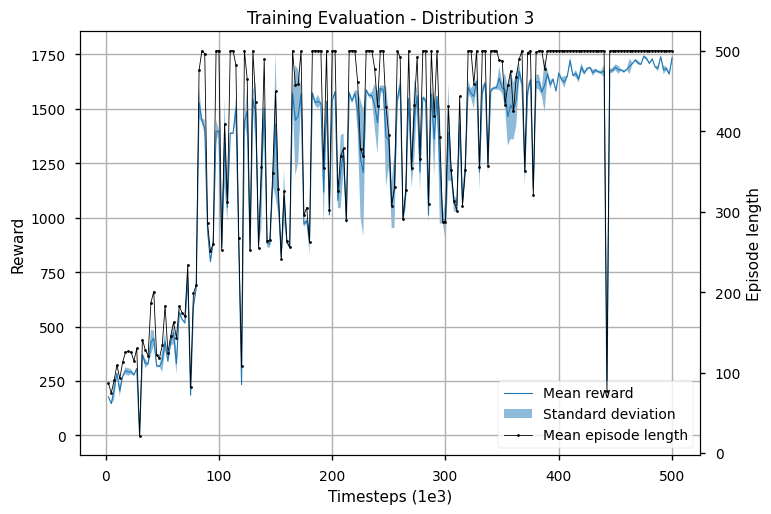

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# back to default settings
mpl.rcParams.update(mpl.rcParamsDefault)

# use a theme
style.use('seaborn-notebook')

x = timesteps/1000
means = np.mean(rewards, axis=1)
stds = np.std(rewards, axis=1)
ep_length_mean = np.mean(ep_length, axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

lns3 = ax2.plot(x, ep_length_mean, "-o", markersize=2, linewidth = 0.6, color='black', alpha=1, label='Mean episode length')
lns1 = ax1.plot(x, means, linewidth = 0.8,label='Mean reward')
lns2 = ax1.fill_between(x, means - stds, means + stds, alpha=0.5, label='Standard deviation')

lns = lns1+[lns2]+lns3
labs = [line.get_label() for line in lns]
ax1.legend(lns, labs, loc='lower right')

ax1.grid()
plt.title('Training Evaluation - Distribution 3', fontsize=12)
ax1.set_xlabel('Timesteps (1e3)')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Episode length')


fig.savefig("rewards_dr.png")
plt.show()